Vorliegendes Notebook widmet sich dem Zweikörper-Problem von Sonne und Erde. \
Die Differentialgleichung zur Bestimmung der Bahnkurven ergeben sich aus dem Gravitationsgesetz zu

$$\ddot{\vec{r}}_S=-G\cdot\frac{m_E}{|\vec{r}_S-\vec{r}_E|^3}\cdot(\vec{r}_S-\vec{r}_E)$$

und 

$$\ddot{\vec{r}}_E=-G\cdot\frac{m_S}{|\vec{r}_S-\vec{r}_E|^3}\cdot(\vec{r}_E-\vec{r}_S).$$

Um diese DGLs 2. Ordnung mit Hilfe der *scipy.integrate.odeint*-Funktion lösen zu können, verwenden wir verallgemeinerte Korrdinaten. Der In- und Out-Put der Funktion lässt sich folgendermaßen in Vektorschreibweise verstehen.

$$\left(\begin{array}{c} r_{x_{Sonne}} \\ \dot{r}_{x_{Sonne}} \\ r_{y_{Sonne}} \\ \dot{r}_{y_{Sonne}} \\ r_{x_{Erde}} \\ \dot{r}_{x_{Erde}} \\ r_{y_{Erde}} \\\dot{r}_{y_{Erde}} \\ \end{array}\right) \;\;\;\; \rightarrow \;\;\;\; \left(\begin{array}{c} \dot{r}_{x_{Sonne}} \\ \ddot{r}_{x_{Sonne}} \\ \dot{r}_{y_{Sonne}} \\ \ddot{r}_{y_{Sonne}} \\ \dot{r}_{x_{Erde}} \\ \ddot{r}_{x_{Erde}} \\ \dot{r}_{y_{Erde}} \\ \ddot{r}_{y_{Erde}} \\ \end{array}\right)$$

Die Ortskoordinaten sowie die Geschwindigkeitskomponenten werden also in die Funktion als Anfangsbedingungen hineingegeben und als Ergebnis erhalten wir die jeweilige Zeit-Ableitung der Vektor-Komponente.

Betrachten wir die Bahnen der beiden Himmelskörper vom Massenschwerpunkt des Systems aus, so stellen wir fest, dass nicht nur die Bewegung der Erde durch die Gravitationskraft der Sonne beeinflusst wird, sondern auch umgekehrt. Um diese Wechselwirkung zu berücksichtigen muss die jeweilige Geschwindigkeit um einen Term korrigiert werden. Betrachtet man die Sonne als ruhend (also $\dot{\vec{r}}_S=0$), so ergibt sich folglich eine korrigierte Geschwindigkeit von

$$\dot{\vec{r}}_{S_{korr}}=\dot{\vec{r}}_S-\frac{m_E}{m_S}\cdot\dot{\vec{r}}_E=\frac{m_E}{m_S}\cdot\dot{\vec{r}}_E$$

für die Sonne und analog dazu eine korrigierte Geschwindigkeit

$$\dot{\vec{r}}_{E_{korr}}=\dot{\vec{r}}_E-\frac{m_S}{m_E}\cdot\dot{\vec{r}}_S=\dot{\vec{r}}_E .$$

für die Erde.\
Den Schwerpunkt können wir aus den Bewegungsdaten von Sonne und Erde mittels

$$\vec{r}_{SP}=\frac{m_S\cdot\vec{r}_S+m_E\cdot\vec{r}_E}{m_S+m_E}$$

berechnen.

Um der besseren Übersicht willen, verwenden wir Grundgrößen im größeren Maßstab und rechnen in astronomischen Einheiten ($AU$) statt Metern, Sonnenmassen statt Kilogramm und Jahren statt Sekunden. \
Als Vorlage für diese Notebook diente zum Teil das zur Verfügung gestellte Beispiel-Notebook "Lösung des Keplerproblems" auf der Moodle-Seite.

In [1]:
import numpy, scipy, scipy.integrate
import matplotlib.pyplot as p

In [2]:
# Definition der Grundgrößen
AU = 1.496e11 # 1 AU in m
year = 365.25*24*60*60 # 1 Jahr in s

M_s = 1.989e30 # Masse der Sonne in kg
m_s = M_s/M_s # Masse der Sonne in Sonnenmassen
m_e = 5.972e24/M_s # Masse der Erde in Sonnenmassen
M = [m_s, m_e]
G = 4 * numpy.pi**2 #Gravitationskonstante in Einheiten der oben festgelegten Grundgrößen

In [3]:
#Definition der Funktion für die Schwerkraft 
def grav_force(y, this_planet, dim):
    if dim == "x":
        coord_offset = 0
    elif dim == "y":
        coord_offset = 2
    else:
        raise NotImplementedError 
    this_offset = 4 * this_planet 
    grav = 0. 
    for i in numpy.arange(len(M)): # Iteriere über Planeten um die paarweise Gravitationskraft zu bestimmen
        if i == this_planet:
            pass # übt keine Kraft auf sich selbst aus
        else:
            x_distance = y[this_offset] - y[4*i]
            y_distance = y[this_offset + 2] - y[4*i + 2]
            grav_t = (y[this_offset + coord_offset] - y[4*i + coord_offset]) 
            grav_t *= 1. / numpy.sqrt(x_distance**2 + y_distance**2)**3
            grav_t *= -G * M[i]
            grav += grav_t
    return grav

#Definition der Funktion für die Zuordnung der verallgemeinerten Koordinaten zu den zeitlichen Ableitungen der verallgemeinerten Koordinaten.
def state_function(y,t):
    n_planets = len(M) 
    f_out = numpy.zeros((int(4 * n_planets)),"float64")
    for i in numpy.arange(n_planets):
        offset = 4 * i # jeder Planet hat eine x' und x'', sowie y' und y'' Komponente
        f_out[offset + 0] = y[offset + 1]
        f_out[offset + 1] = grav_force(y, this_planet=i, dim="x")
        f_out[offset + 2] = y[offset + 3]
        f_out[offset + 3] = grav_force(y, this_planet=i, dim="y")
    return f_out

In [4]:
#Anfangsbedingungen 
r_ES = 1.496e11/AU #Abstand Sonne-Erde
v_E = 29.78e3*year/AU #Geschwindigkeitsbetrag der Erde
y0 = [0, # x-Koordinate der Sonne
      v_E*m_e/m_s, #vx-Komponente der Sonne
      0, #y-Koodinate der Sonne
      0, #vy-Komponente der Sonne
      0, #x-Koodinate der Erde
      -v_E, #vx-Komponente der Erde
      r_ES, #y-Koodinate der Erde
      0] #vy-Komponente der Erde

In [5]:
timespan = numpy.linspace(0,1,10001) #Zeitspanne von einem Jahr

In [6]:
# Odeint-Funktion zur Berechnung der Differentialgleichung
y = scipy.integrate.odeint(state_function,y0,t=timespan) 

In [7]:
# Für verschiedene rtols
ys = []  
results = []
for i in numpy.arange(1,6): #Schleife für die verschiedene rtol bzw. hmax 
    end_result = scipy.integrate.odeint(state_function,y0,t=timespan,rtol=numpy.float(f"1e-{i}"),hmax=numpy.float(f"1e-{i}"), mxstep=10000000)
    ys.append(end_result) #fügt die Ergebnisse zu List zusammen
    group_result = []
    for n in numpy.arange(-10, 0, 1): #Schleife, um die jeweils letzten 10 y-Ergebnis-Paare zu bekommen
        diffs = numpy.linalg.norm((end_result[n, 0] - y0[0]) - (end_result[n, 2] - y0[2])) #euklidische Norm, um den kleinsten Abstand zu den Anfangskoordinaten zu finden
        group_result.append(diffs) 
    results.append(min(group_result)) #nimmt den jeweils kleinsten Abstand-Wert und packt in results-Liste

print(f'Der kleinste Abstand von Anfangs- zu Endposition der Umlaufbahn der Erde nach einem Jahr wird mit einer Toleranz von r_tol=1e-{results.index(min(results))} erreicht.') #gibt den Index des kleinsten Wertes aus der results-Liste

Der kleinste Abstand von Anfangs- zu Endposition der Umlaufbahn der Erde nach einem Jahr wird mit einer Toleranz von r_tol=1e-2 erreicht.


In [8]:
#Berechnung des Schwerpunktes
sp = numpy.zeros((10001, 2))
sp[:, 0] = (m_s * y[:, 0] + m_e * y[:, 4]) / (m_s + m_e) #x-Koordinate des Schwerpunkts
sp[:, 1] = (m_s * y[:, 2] + m_e * y[:, 6]) / (m_s + m_e) #y-Koordinate des Schwerpunkts

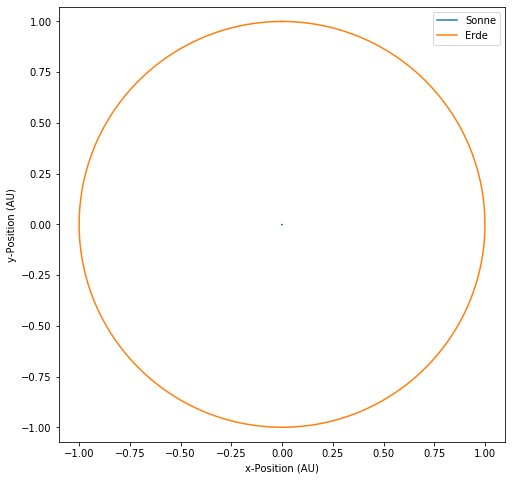

In [9]:
# Plot der Erdbahn um die Sonne
fig = p.figure(figsize=(8,8))
for i in numpy.arange(len(M)):
    p.plot(y[:,4*i], y[:,4*i+2], ls="-", label=["Sonne","Erde"][i]) #x-Koordinate = 0. bzw 4. Element aus odeint-Liste y, y-Koordinate = 2. bzw 6. Element aus odeint-Liste y
    p.xlabel("x-Position (AU)")
    p.ylabel("y-Position (AU)")
    p.axis("equal")
    p.legend()    
p.show()

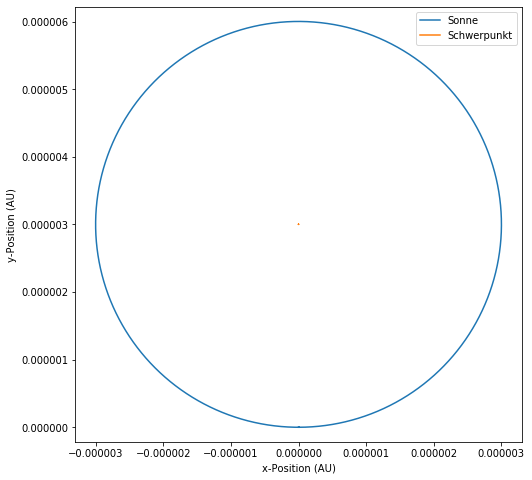

In [10]:
# Plot der Sonnenbahn um den Schwerpunkt
fig = p.figure(figsize=(8,8))
p.plot(y[:,0], y[:,2], ls="-", label="Sonne")
p.plot(sp[:,0], sp[:,1], ls="-", label="Schwerpunkt")
p.xlabel("x-Position (AU)")
p.ylabel("y-Position (AU)")
p.axis("equal") 
p.legend()
p.show()

In [11]:
#Für r_ES = 0.6 * r_ES
y0_kl = [0, # x-Koordinate der Sonne
      v_E*m_e/m_s, #vx-Komponente der Sonne
      0, #y-Koodinate der Sonne
      0, #vy-Komponente der Sonne
      0, #x-Koodinate der Erde
      -v_E, #vx-Komponente der Erde
      0.6*r_ES, #y-Koodinate der Erde
      0] #vy-Komponente der Erde

#Für r_ES = 1.4 * r_ES
y0_gr = [0, # x-Koordinate der Sonne
      v_E*m_e/m_s, #vx-Komponente der Sonne
      0, #y-Koodinate der Sonne
      0, #vy-Komponente der Sonne
      0, #x-Koodinate der Erde
      -v_E, #vx-Komponente der Erde
      1.4*r_ES, #y-Koodinate der Erde
      0] #vy-Komponente der Erde

# Für r_ES = 0.6*r_ES und rtol = default, hmax = default
yd_kl = scipy.integrate.odeint(state_function,y0_kl,t=2*timespan) 

# Für r_ES = 1.4*r_ES und rtol = default, hmax = default
yd_gr = scipy.integrate.odeint(state_function,y0_gr,t=4*timespan)

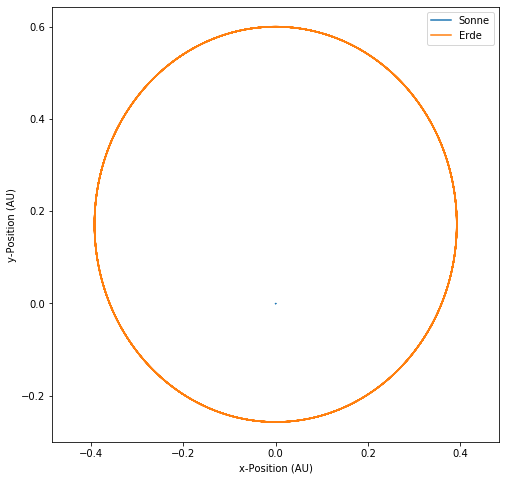

In [12]:
# Plot der Erdbahn um die Sonne mit r_ES=0.6*r_ES
fig = p.figure(figsize=(8,8))
for i in numpy.arange(len(M)):
    p.plot(yd_kl[:,4*i], yd_kl[:,4*i+2], ls="-", label=["Sonne","Erde"][i])
    p.xlabel("x-Position (AU)")
    p.ylabel("y-Position (AU)")
    p.axis("equal")
    p.legend()    
p.show()

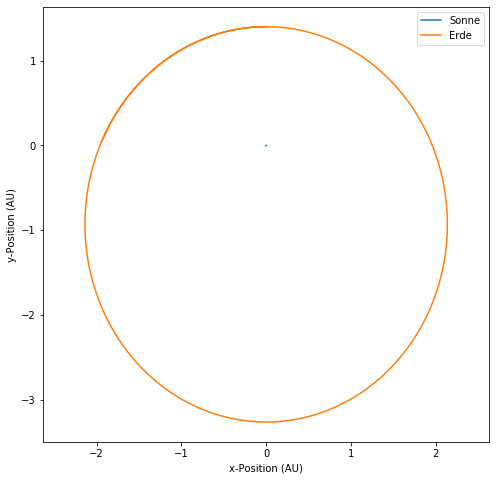

In [13]:
# Plot der Erdbahn um die Sonne mit r_ES=1.4*r_ES
fig = p.figure(figsize=(8,8))
for i in numpy.arange(len(M)):
    p.plot(yd_gr[:,4*i], yd_gr[:,4*i+2], ls="-", label=["Sonne","Erde"][i])
    p.xlabel("x-Position (AU)")
    p.ylabel("y-Position (AU)")
    p.axis("equal")
    p.legend()    
p.show()